Natural image scene discrimination in mouse visual cortices
applied linear svm classifier (L2 penalty) penalaty

# 0. Import Libraries
import libraries neded

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
import numpy as np
import pprint
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn import svm,cross_validation
from sklearn.grid_search import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.utils import shuffle
from __future__ import print_function
import h5py
from matplotlib.backends.backend_pdf import PdfPages
import datetime

%matplotlib inline

# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache(manifest_file='boc/manifest.json')
area_labels = ['PM','AL', 'LM', 'V1']


# 1. Find Regularization parameter (C)
Perform parameter search to find "best" regularization parameter C for the SVM. 


In [ ]:
#Gridsearch CV

areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
nfolds = 3
C_params = list()
best_scores = list()
test_scores = list()
stim_onset = 7

C_s = np.concatenate((np.logspace(-7, -0.05, 5),[1],np.logspace(0.05, 7, 5)))

for aa in range(len(areas)):
    start_total = datetime.datetime.now()
    
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        XT_ALL = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
        
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore     
    X_range = XT_ALL[50:,:,stim_onset+6:stim_onset+10] #select range approximately 200 to 300ms from stimulus onset
    X_ALL = np.mean(X_range,axis=2) #compute euclidean norm
    X_train,X_test,y_train,y_test = train_test_split(X_ALL,y,test_size=0.3)   
    
    #scale each feature [0,1]
    if scale:
        scaler = preprocessing.MinMaxScaler()
        X_train_scale = scaler.fit_transform(X_train)
        X_test_scale = scaler.fit_transform(X_test)
    else:
        #normalize the response of each neuron to zero mean and unit variance
        #this uses a lot of memory. consider running on faster machine
        scaler = preprocessing.StandardScaler(copy=False).transform(X_train)
        X_train_scale = scaler.transform(X_train)
        X_test_scale = scaler.transform(X_test)
            
    SVC = LinearSVC()
    clf = GridSearchCV(estimator=SVC, param_grid=dict(C=C_s), n_jobs=1,cv=nfolds,scoring='accuracy')
    clf.fit(X_train, y_train)        
    
    end_total = datetime.datetime.now()
    print('elapsed time: %d seconds' %(end_total - start_total).total_seconds())
    
    C_params.append(clf.best_estimator_.C)
    best_scores.append(100 * clf.best_score_)
    test_scores.append(100 * clf.score(X_test,y_test))
    
    print(this_area + ' best score: %0.2f' %(100 * clf.best_score_))
    print(this_area + ' best estimator: %0.4f' %(clf.best_estimator_.C))
    print(this_area + ' test score: %0.2f' %(100 * clf.score(X_test,y_test)))

# 2. Classification accuracy per visual area and across time
trained classifier with mean activity from 200-300ms post-stimulus onset

In [7]:
colors = ['red','blue','green','cyan']
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
#first 7 frames before stimulus, 7 stimulus ON frames followed by 7 frames post stimulus.
#please note that in the actual experiment there was no 
#blank period between frames, i.e. stimuli were presented consecutively. 
stim_onset = 7 #occurs after first 7 frames
stim_frames = 7

niter = 10     #run classifier. repeat 10x and average
num_cells_per_area = list()
acq_fps = float(30.1)
limit_num_neurons = 0
time_test_subset = 0
single_frame = 0
scale = 1

for aa in range(len(areas)):
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    #load hdf5 file
    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        X = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
    
    XT_ALL = X[50:,:,:] #first 50 trials belongs to blank, ignore 
    y = np.median(Y_ALL,axis=0).astype(int)[50:] #first 50 trials belongs to blank, ignore 
    y_shuffle = shuffle(y)
    
    #select range approximately 200 to 300ms from stimulus onset
    X_train_range = XT_ALL[:,:,stim_onset+6:stim_onset+10] 

    #compute mean
    X_ALL = np.mean(X_train_range,axis=2)
    add_filename = '_mean'
    
    if single_frame: #pick single frame
        #stim_onset+6 = approx 200ms post stimulus onset, stim_onset+9 ~approx 300ms post stim
        X_ALL = XT_ALL[:,:,stim_onset+6] 
        add_filename = '_frame'
        
    #select range for testing classifier across time: 250 ms (7 frames) before stim onset & 250ms 
    #post stimulus onset (14 frames post stimulus onset)
    XT_test_range = XT_ALL
    
    num_cells_per_area.append(X.shape[1])
    accuracy_per_iter = list()
    accuracy_per_iter_shuffle = list()
    
    num_neurons_include = num_cells_per_area[aa]
    add_filename = add_filename + '_all_neurons'
        
    if limit_num_neurons:
        num_neurons_include = 2100 
        add_filename = add_filename + '_2100_neurons'

    for ii in range(niter):
        inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
        Xn = X_ALL[:,inds]
        XTn = XT_test_range[:,inds,:]

        #for cross validation do, 70/30 split.
        X_train,X_test,y_train,y_test = train_test_split(Xn,y,test_size=0.3) 
        y_train_shuffle = shuffle(y_train)
        y_test_shuffle = shuffle(y_test)
        
        #scale each feature [0,1]
        if scale:
            scaler = preprocessing.MinMaxScaler()
            X_train_scale = scaler.fit_transform(X_train)
            X_test_scale = scaler.fit_transform(X_test)
        else:
            #normalize the response of each neuron to zero mean and unit variance
            #this uses a lot of memory. consider running on faster machine
            scaler = preprocessing.StandardScaler(copy=False).transform(X_train)
            X_train_scale = scaler.transform(X_train)
            X_test_scale = scaler.transform(X_test)
            
        # train linear SVM classifier on data
        linearSVM_1 = OneVsRestClassifier(LinearSVC(C=0.0163))
        linearSVM_1.fit(X_train_scale, y_train)
        accuracy_per_iter.append(100*linearSVM_1.score(X_test_scale,y_test))
        
        # train linear SVM classifier on shuffled data
        linearSVM_1_shuffle = OneVsRestClassifier(LinearSVC(C=0.0163))
        linearSVM_1_shuffle.fit(X_train_scale, y_train_shuffle)
        accuracy_per_iter_shuffle.append(100*linearSVM_1_shuffle.score(X_test_scale,y_test_shuffle)) 

        # test decoding accuracy across time
        window_frames_to_plot = XTn.shape[2]
        accuracy_time = list()
        accuracy_time_shuffle = list()
        
        for w in np.arange(0,window_frames_to_plot):
            X_data_test = XTn[:,:,w]
            if time_test_subset: #select subset (30%) of data to test
                X_train_time,X_test_time,y_train_time,y_test_time = train_test_split(X_data_test,y,test_size=0.3)
            else:
                X_test_time = X_data_test
                y_test_time = y
            X_test_scale = scaler.transform(X_test_time)
            accuracy_time.append(100*linearSVM_1.score(X_test_scale,y_test_time))
            y_shuffle_time = shuffle(y_test_time)
            accuracy_time_shuffle.append(100*linearSVM_1_shuffle.score(X_test_scale,y_shuffle_time))

        if ii == 0:
            accuracy_time_all = accuracy_time
            accuracy_time_all_shuffle = accuracy_time_shuffle
        if ii > 0:
            accuracy_time_all = np.vstack((accuracy_time_all,np.array(accuracy_time)))
            accuracy_time_all_shuffle = np.vstack((accuracy_time_all_shuffle,np.array(accuracy_time_shuffle)))

    mean_accuracy = np.mean(np.array(accuracy_per_iter))
    std_accuracy = np.std(np.array(accuracy_per_iter)) / np.sqrt(niter)    
    mean_accuracy_shuffle = np.mean(np.array(accuracy_per_iter_shuffle))
    std_accuracy_shuffle = np.std(np.array(accuracy_per_iter_shuffle)) / np.sqrt(niter)    

    print(this_area + ', mean test accuracy: %0.2f (+/- %0.2f), mean shuffle accuracy: %0.2f (+/- %0.2f)'
          %(mean_accuracy,std_accuracy,mean_accuracy_shuffle,std_accuracy_shuffle))

    mean_accuracy_time = np.mean(accuracy_time_all,axis=0)
    std_accuracy_time = np.std(accuracy_time_all,axis=0) / np.sqrt(niter)
    mean_accuracy_time_shuffle = np.mean(accuracy_time_all_shuffle,axis=0)
    std_accuracy_time_shuffle = np.std(accuracy_time_all_shuffle,axis=0) / np.sqrt(niter)
    
    if aa == 0:
        mean_accuracy_time_all = mean_accuracy_time
        std_accuracy_time_all = std_accuracy_time
        mean_accuracy_per_area = mean_accuracy
        std_accuracy_per_area = std_accuracy
        
        mean_accuracy_time_all_shuffle = mean_accuracy_time_shuffle
        std_accuracy_time_all_shuffle = std_accuracy_time_shuffle
        mean_accuracy_per_area_shuffle = mean_accuracy_shuffle
        std_accuracy_per_area_shuffle = std_accuracy_shuffle
        
    if aa > 0:
        mean_accuracy_time_all = np.vstack((mean_accuracy_time_all,mean_accuracy_time))
        std_accuracy_time_all = np.vstack((std_accuracy_time_all,std_accuracy_time))
        mean_accuracy_per_area = np.vstack((mean_accuracy_per_area,mean_accuracy))
        std_accuracy_per_area = np.vstack((std_accuracy_per_area,std_accuracy))
        
        mean_accuracy_time_all_shuffle = np.vstack((mean_accuracy_time_all_shuffle,mean_accuracy_time_shuffle))
        std_accuracy_time_all_shuffle = np.vstack((std_accuracy_time_all_shuffle,std_accuracy_time_shuffle))
        mean_accuracy_per_area_shuffle = np.vstack((mean_accuracy_per_area_shuffle,mean_accuracy_shuffle))
        std_accuracy_per_area_shuffle = np.vstack((std_accuracy_per_area_shuffle,std_accuracy_shuffle))
        
    num_classes = np.max(linearSVM_1.classes_)

if time_test_subset:
    add_filename = add_filename + '_test_subset'

VISpm, mean test accuracy: 34.45 (+/- 0.48), mean shuffle accuracy: 0.71 (+/- 0.08)
VISal, mean test accuracy: 34.99 (+/- 0.78), mean shuffle accuracy: 0.93 (+/- 0.08)
VISl, mean test accuracy: 53.87 (+/- 0.29), mean shuffle accuracy: 0.80 (+/- 0.06)
VISp, mean test accuracy: 76.07 (+/- 0.72), mean shuffle accuracy: 0.85 (+/- 0.07)


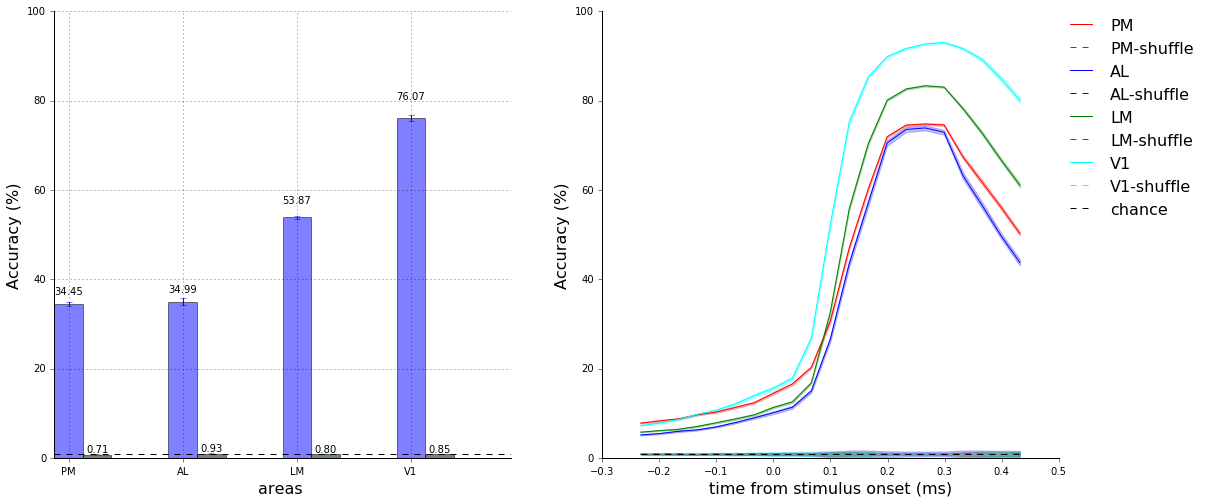

In [8]:
#make pretty plots
num_areas =len(areas)
inds =np.arange(num_areas) 
chance_val = 100 /float(1 + num_classes)
xtime = (1/acq_fps)*(np.arange(-7,14))

fig = plt.figure(figsize=(18,8))
ax = plt.subplot(121)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')

plt.ylabel('Accuracy (%)',fontsize=16)
plt.xlabel('areas ', fontsize=16)
bar_width = 0.25

bar1 = plt.bar(inds,mean_accuracy_per_area,alpha=0.5, yerr=std_accuracy_per_area[:,0],
               width=bar_width)
bar2 = plt.bar(inds+bar_width,mean_accuracy_per_area_shuffle,alpha=0.5, 
               yerr=std_accuracy_per_area_shuffle[:,0],
               width=bar_width, color='black')
chance = chance_val*np.ones(len(areas))
xs = np.linspace(0,num_areas,num=num_areas)
plt.plot(xs,chance,ls='--',color='black',label='chance')
plt.xticks(inds + 0.5 * bar_width,area_labels)
plt.grid()
ax.set_ylim(0,100)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,'%0.02f' 
                %(height),ha='center', va='bottom')
autolabel(bar1)
autolabel(bar2)

ax = plt.subplot(122)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')
ax.set_ylim(0,100)

for aa in range(len(areas)):
    plt.plot(xtime,mean_accuracy_time_all[aa,:],label=area_labels[aa],color=colors[aa])
    upper = mean_accuracy_time_all[aa,:] + std_accuracy_time_all[aa,:]
    lower = mean_accuracy_time_all[aa,:] - std_accuracy_time_all[aa,:]
    plt.fill_between(xtime,lower,upper,alpha=0.25,color=colors[aa])
    
    plt.plot(xtime,mean_accuracy_time_all_shuffle[aa,:],label=area_labels[aa]+'-shuffle',
             ls='--',color=colors[aa])
    upper_shuffle = mean_accuracy_time_all_shuffle[aa,:] + std_accuracy_time_all[aa,:]
    lower_shuffle = mean_accuracy_time_all_shuffle[aa,:] - std_accuracy_time_all[aa,:]
    plt.fill_between(xtime,lower_shuffle,upper_shuffle,alpha=0.25,color=colors[aa])

plt.ylabel('Accuracy (%)',fontsize=16)
plt.xlabel('time from stimulus onset (ms)', fontsize=16)

chance = chance_val*np.ones(window_frames_to_plot)
plt.plot(xtime,chance,ls='--',color='black',label='chance')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy all visual areas'+ add_filename + '.pdf') as pdf:
    pdf.savefig(fig)

# 3. decoder accuracy per number of neurons - per area

In [9]:
colors = ['red','blue','green','cyan']
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
niter = 10
scale = 1

for aa in range(len(areas)):
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        XT_ALL = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)

    y = np.median(Y_ALL,axis=0).astype(int)[50:] #select ignore first 50 trials which belong to blank
    y_shuffle = shuffle(y)
    #select range approximately 200 to 300ms from stimulus onset, ignore first 50 trials
    X_range = XT_ALL[50:,:,stim_onset+6:stim_onset+10] 
    #compute mean
    X_ALL = np.mean(X_range,axis=2)
    add_filename = '_mean_'

    total_num_cells = X_ALL.shape[1]
    percentages = np.array([0.03,1,5, 10, 25, 50, 75, 100])
    num_neurons_list =list(np.rint(total_num_cells * percentages/float(100)))

    accuracy_per_neuron_count = np.empty([niter,len(num_neurons_list)])
    accuracy_per_neuron_count[:] = np.nan
    accuracy_per_neuron_count_shuffle = np.empty([niter,len(num_neurons_list)])
    accuracy_per_neuron_count_shuffle[:] = np.nan

    for ii in range(niter):
        for nn in range(len(num_neurons_list)):
            this_num_neurons = int(num_neurons_list[nn])
            inds = np.random.randint(0,total_num_cells,(this_num_neurons,))
            Xn = X_ALL[:,inds]
            #randomly select 30% of samples for test dataset
            Xn_train,Xn_test,yn_train,yn_test = train_test_split(Xn,y,test_size=0.3)
            
            if scale:
                scaler = preprocessing.MinMaxScaler()
                Xn_train_scale = scaler.fit_transform(Xn_train)
                Xn_test_scale = scaler.fit_transform(Xn_test)
            else:
                #normalize data to zero mean and unit variance
                scaler = preprocessing.StandardScaler(copy=False).fit(Xn_train)
                Xn_train_scale = scaler.transform(Xn_train)
                Xn_test_scale = scaler.transform(Xn_test)

            # train linear SVM classifier - to data
            linearSVM = OneVsRestClassifier(LinearSVC(C=0.0163))
            linearSVM.fit(Xn_train_scale, yn_train)
            accuracy = 100*linearSVM.score(Xn_test_scale,yn_test) 
            accuracy_per_neuron_count[ii,nn] = accuracy
            
            #train linear SVM on shuffled data
            yn_train_shuffle = shuffle(yn_train)
            yn_test_shuffle = shuffle(yn_test)
            linearSVM_shuffle = OneVsRestClassifier(LinearSVC(C=0.0163))
            linearSVM_shuffle.fit(Xn_train_scale, yn_train_shuffle)
            accuracy_shuffle = 100*linearSVM_shuffle.score(Xn_test_scale,yn_test_shuffle) 
            accuracy_per_neuron_count_shuffle[ii,nn] = accuracy_shuffle

    #compute mean and std of accuracy over iterations for data and shuffle
    mean_accuracy = np.nanmean(accuracy_per_neuron_count,axis=0)
    std_accuracy = np.nanstd(accuracy_per_neuron_count,axis=0) / np.sqrt(niter)
    mean_accuracy_shuffle = np.nanmean(accuracy_per_neuron_count_shuffle,axis=0)
    std_accuracy_shuffle = np.nanstd(accuracy_per_neuron_count_shuffle,axis=0) / np.sqrt(niter)
    
    if aa == 0:
        mean_accuracy_per_neuron_count_per_area = mean_accuracy
        std_accuracy_per_neuron_count_per_area = std_accuracy
        mean_accuracy_per_neuron_count_per_area_shuffle = mean_accuracy_shuffle
        std_accuracy_per_neuron_count_per_area_shuffle = std_accuracy_shuffle
        neuron_count_per_area = num_neurons_list

    else:
        mean_accuracy_per_neuron_count_per_area = np.vstack((mean_accuracy_per_neuron_count_per_area,mean_accuracy))
        std_accuracy_per_neuron_count_per_area = np.vstack((std_accuracy_per_neuron_count_per_area,std_accuracy))
        mean_accuracy_per_neuron_count_per_area_shuffle = np.vstack((mean_accuracy_per_neuron_count_per_area_shuffle, 
                                                                     mean_accuracy_shuffle))
        std_accuracy_per_neuron_count_per_area_shuffle = np.vstack((std_accuracy_per_neuron_count_per_area_shuffle, 
                                                                    std_accuracy_shuffle))
        neuron_count_per_area = np.vstack((neuron_count_per_area,num_neurons_list))    
    print(this_area)
    
print('-----Done-----')

VISpm
VISal
VISl
VISp
-----Done-----


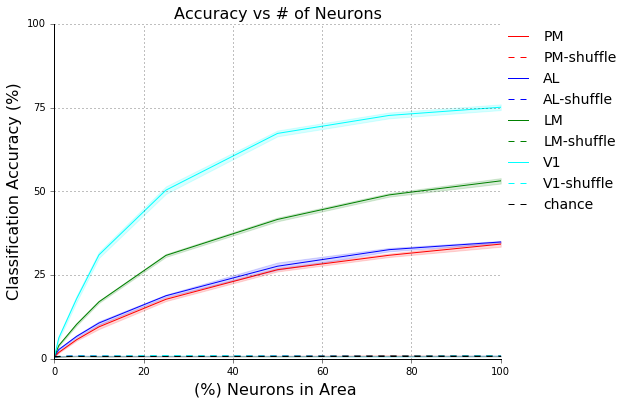

In [10]:
#make pretty plots
fig = plt.figure(figsize=(8,6))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')

ax.set_ylim(0,100)
plt.ylabel('Classification Accuracy (%)',fontsize=16)
plt.xlabel('(%) Neurons in Area ', fontsize=16)
plt.title( 'Accuracy vs # of Neurons',fontsize=16)

for aa in range(len(areas)):
    plt.plot(percentages,mean_accuracy_per_neuron_count_per_area[aa,:],ls='-',
             label=area_labels[aa],color=colors[aa])
    upper = mean_accuracy_per_neuron_count_per_area[aa,:] + std_accuracy_per_neuron_count_per_area[aa,:]
    lower = mean_accuracy_per_neuron_count_per_area[aa,:] - std_accuracy_per_neuron_count_per_area[aa,:]
    plt.fill_between(percentages,lower,upper,alpha=0.15,color=colors[aa])
    
    plt.plot(percentages,mean_accuracy_per_neuron_count_per_area_shuffle[aa,:],ls='--',
             label=area_labels[aa] + '-shuffle',color = colors[aa])
    upper_shuffle = mean_accuracy_per_neuron_count_per_area_shuffle[aa,:] + std_accuracy_per_neuron_count_per_area_shuffle[aa,:]
    lower_shuffle = mean_accuracy_per_neuron_count_per_area_shuffle[aa,:] - std_accuracy_per_neuron_count_per_area_shuffle[aa,:]
    plt.fill_between(percentages,lower_shuffle,upper_shuffle,alpha=0.15,color=colors[aa])

chance = (100/float(119))*np.ones(len(percentages))
plt.plot(percentages,chance,ls='--',color='black',label='chance')
plt.legend(bbox_to_anchor=(0.995, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=14)
plt.yticks([0, 25 ,50,75, 100])
plt.grid()

with PdfPages('Decoder accuracy per number neurons per visual area' + add_filename + '.pdf') as pdf:
    pdf.savefig(fig)


# 4. train & test classifier at each time point - per area
consider running on cluster/gpu. this takes awhile

In [ ]:
colors = ['red','blue','green','cyan']
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
#first 28 frames is considered baseline for calculating df/f,followed by 7 stimulus ON frames
# followed by 28 frames post stimulus. please note that in the actual experiment there was no 
#blank period between frames, i.e. stimuli were presented consecutively. 
stim_onset = 7 #occurs after first 7 frames
stim_frames = 7

niter = 3     #run classifier with different cross validation
num_cells_per_area = np.empty(len(areas))
num_cells_per_area[:] = np.nan
acq_fps = float(30.1)
scale = 1
add_to_filename = '_all_'
num_cells_per_area  = list()

for aa in range(len(areas)):
    this_area = areas[aa]
    filename = this_area + '_sweeps_data.h5'

    #load hdf5 file
    with h5py.File(filename,'r') as hf:
        data_1 = hf.get('X_matrix_time')
        XT_ALL = np.array(data_1)
        data_2 = hf.get('Y_matrix')
        Y_ALL = np.array(data_2)
        data_3 = hf.get('cell_IDs')
        cell_IDs = np.array(data_3)

    y = np.median(Y_ALL,axis=0).astype(int)[50:] #select ignore first 50 trials which belong to blank
    y_shuffle = shuffle(y)
    #select range for testing classifier across time: 250 ms (7 frames) 
    #before stim onset & 250ms post stimulus onset (14 frames post stimulus onset)
    XT_test_range = XT_ALL[50:,:,:]
    frames_to_test = XT_test_range.shape[2]
    num_cells_per_area.append(len(cell_IDs))
    num_neurons_include = num_cells_per_area[aa]
           
    for ii in range(niter):
        inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
        XTn = XT_test_range[:,inds,:]
        accuracy_time = list()
        accuracy_time_shuffle = list()
        
        for w in np.arange(0,frames_to_test):
            X_frame = XTn[:,:,w]
            
            #for cross validation do, 70/30 split.
            X_train,X_test,y_train,y_test = train_test_split(X_frame,y,test_size=0.3) 
            y_train_shuffle = shuffle(y_train)
            y_test_shuffle = shuffle(y_test)
            
            if scale: #scale from [0,1]
                scaler = preprocessing.MinMaxScaler()
                X_train_scale = scaler.fit_transform(X_train)
                X_test_scale = scaler.fit_transform(X_test)
            else:
                #normalize the response of each neuron to zero mean and unit variance
                scaler = preprocessing.StandardScaler(copy=False).fit(X_train)
                X_train_scale = scaler.transform(X_train)
                X_test_scale = scaler.transform(X_test)
            
            # train linear SVM classifier on data
            linearSVM_1 = OneVsRestClassifier(LinearSVC(C=0.0163))
            linearSVM_1.fit(X_train_scale, y_train)
            # train linear SVM classifier on shuffled data
            linearSVM_1_shuffle = OneVsRestClassifier(LinearSVC(C=0.0163))
            linearSVM_1_shuffle.fit(X_train_scale, y_train_shuffle)
            
            accuracy_time.append((100*linearSVM_1.score(X_test_scale,y_test)))
            accuracy_time_shuffle.append((100*linearSVM_1_shuffle.score(X_test_scale,y_test_shuffle))) 

        if ii == 0:
            accuracy_time_all = np.array(accuracy_time)
            accuracy_time_all_shuffle = np.array(accuracy_time_shuffle)
        if ii > 0:
            accuracy_time_all = np.vstack((accuracy_time_all,np.array(accuracy_time)))
            accuracy_time_all_shuffle = np.vstack((accuracy_time_all_shuffle,np.array(accuracy_time_shuffle)))

    mean_accuracy_time = np.mean(accuracy_time_all,axis=0)
    std_accuracy_time = np.std(accuracy_time_all,axis=0) / np.sqrt(niter)
    mean_accuracy_time_shuffle = np.mean(accuracy_time_all_shuffle,axis=0)
    std_accuracy_time_shuffle = np.std(accuracy_time_all_shuffle,axis=0) / np.sqrt(niter)
    
    if aa == 0:
        mean_accuracy_time_all = mean_accuracy_time
        std_accuracy_time_all = std_accuracy_time
        
        mean_accuracy_time_all_shuffle = mean_accuracy_time_shuffle
        std_accuracy_time_all_shuffle = std_accuracy_time_shuffle
        
    if aa > 0:
        mean_accuracy_time_all = np.vstack((mean_accuracy_time_all,mean_accuracy_time))
        std_accuracy_time_all = np.vstack((std_accuracy_time_all,std_accuracy_time))
        mean_accuracy_time_all_shuffle = np.vstack((mean_accuracy_time_all_shuffle,mean_accuracy_time_shuffle))
        std_accuracy_time_all_shuffle = np.vstack((std_accuracy_time_all_shuffle,std_accuracy_time_shuffle))
      
    num_classes = np.max(linearSVM_1.classes_)



In [ ]:
#make pretty plots
num_areas =len(areas)
inds =np.arange(num_areas)
chance_val = 100 /float(1 + num_classes)
xtime = (1/acq_fps)*(np.arange(-7,14))

fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')
ax.set_ylim(0,100)

trange = np.arange(0,len(xtime))
for aa in range(len(areas)):
    plt.plot(xtime[trange],mean_accuracy_time_all[aa,trange],label=area_labels[aa],color=colors[aa])
    upper = mean_accuracy_time_all[aa,trange] + std_accuracy_time_all[aa,trange]
    lower = mean_accuracy_time_all[aa,trange] - std_accuracy_time_all[aa,trange]
    plt.fill_between(xtime[trange],lower,upper,alpha=0.25,color=colors[aa])
    
    plt.plot(xtime[0:15],mean_accuracy_time_all_shuffle[aa,0:15],label=area_labels[aa]+'-shuffle',
             ls='--',color=colors[aa])
    upper_shuffle = mean_accuracy_time_all_shuffle[aa,trange] + std_accuracy_time_all[aa,trange]
    lower_shuffle = mean_accuracy_time_all_shuffle[aa,trange] - std_accuracy_time_all[aa,trange]
    plt.fill_between(xtime[trange],lower_shuffle,upper_shuffle,alpha=0.25,color=colors[aa])

plt.ylabel('Accuracy (%)',fontsize=16)
plt.xlabel('time from stimulus onset (ms)', fontsize=16)

chance = chance_val*np.ones(frames_to_test)
plt.plot(xtime,chance,ls='--',color='black',label='chance')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy across time'+ add_to_filename +'.pdf') as pdf:
    pdf.savefig(fig)

# 5. Cell type-specific classifier

In [47]:
areas = [ 'VISpm', 'VISal', 'VISl', 'VISp']
cre_lines = ['Cux2-CreERT2','Rorb-IRES2-Cre','Rbp4-Cre'] #layer 2/3 & 4, layer 4, layer 5
add_filename = '_all_neurons'

niter = 10 
acq_fps = float(30.1)
num_areas = len(areas)
num_cre_lines = len(cre_lines)
scale = 1
limit_neurons = 1
#intialize variables for storage
mean_accuracy_per_cre_area = np.empty([num_areas,num_cre_lines])
mean_accuracy_per_cre_area[:] = np.nan
std_accuracy_per_cre_area = np.empty([num_areas,num_cre_lines])
std_accuracy_per_cre_area[:] = np.nan
num_cells_per_cre_area = np.empty([num_areas,num_cre_lines])
num_cells_per_cre_area[:] = np.nan

mean_accuracy_time_per_cre_area = np.empty([num_cre_lines,21,num_areas]) #21 frames included
mean_accuracy_time_per_cre_area[:] = np.nan
std_accuracy_time_per_cre_area = np.empty([num_cre_lines,21,num_areas]) #21 frames included
std_accuracy_time_per_cre_area[:] = np.nan

for aa in range(num_areas):
    this_area = areas[aa]
    
    for c in range(num_cre_lines):
        this_cre = cre_lines[c]
        this_filename = this_area + '_'+ this_cre +'_sweeps_data.h5'
        with h5py.File(this_filename,'r') as hf:
            data_1 = hf.get('X_matrix_time')
            XT_ALL = np.array(data_1)
            data_2 = hf.get('Y_matrix')
            Y_ALL = np.array(data_2)
    
        y = np.median(Y_ALL,axis=0).astype(int)[50:] #select ignore first 50 trials which belong to blank
        XT_ALL = XT_ALL[50:,:,:]
        X_range = XT_ALL[:,:,stim_onset+6:stim_onset+10] #select range approximately 200 to 300ms from stimulus onset
        X_ALL = np.mean(X_range,axis=2) #compute magnitude (euclidean norm)
        
        num_cells_per_cre_area[aa,c] = X_ALL.shape[1]
        num_neurons_include = num_cells_per_cre_area[aa,c]

        if limit_neurons:
            print('-----' + str(200) + ' neurons limit-----')
            num_neurons_include = 200
            add_filename = '_200_neurons'
            
        accuracy_per_iter = list()
        
        #run classifier 
        for ii in range(niter):
            inds = np.random.randint(0,num_neurons_include,size=num_neurons_include)
            X = X_ALL[:,inds]
            XT = XT_ALL[:,inds,:]
        
            #for cross validation do, 70/30 split. repeat 10 times and average
            X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

            if scale:
                #scale data X [0,1] - important to scale data. prevents features with high values from dominating. 
                scaler = preprocessing.MinMaxScaler()
                X_train_scale = scaler.fit_transform(X_train)
                X_test_scale = scaler.transform(X_test)
            else:
                #normalize the response of each neuron to zero mean and unit variance
                scaler = preprocessing.StandardScaler(copy=False).fit(X_train)
                X_train_scale = scaler.transform(X_train)
                X_test_scale = scaler.transform(X_test)
                
            # linear SVM classifier - to data
            linearSVM_2 = OneVsRestClassifier(LinearSVC(C=0.0163))
            linearSVM_2.fit(X_train_scale, y_train)
            accuracy_per_iter.append(100*linearSVM_2.score(X_test_scale,y_test) ) 

            # decoding accuracy across time
            time_points = XT.shape[2]
            accuracy_time = list()

            for w in range(time_points):
                X_test = XT[:,:,w]
                X_test_scale = scaler.transform(X_test)
                accuracy_time.append(100*linearSVM_2.score(X_test_scale,y))
            
            if ii == 0:
                accuracy_time_all_iter = np.array(accuracy_time)
            if ii > 0:
                accuracy_time_all_iter = np.vstack((accuracy_time_all_iter,np.array(accuracy_time)))
        
        #mean accuracy over iterations
        mean_accuracy_per_cre_area[aa,c] = np.mean(np.array(accuracy_per_iter))
        std_accuracy_per_cre_area[aa,c] = np.std(np.array(accuracy_per_iter)) / (np.sqrt(niter)) 
        
        #mean accuracy across time over iterations
        mean_accuracy_time_per_cre_area[c,:,aa] = np.mean(accuracy_time_all_iter, axis=0)
        std_accuracy_time_per_cre_area[c,:,aa] = np.std(accuracy_time_all_iter, axis=0)

        print(this_area + ', ' + this_cre + ', %d cells, Mean Test accuracy: %0.4f (+/- %0.4f)' 
              %(num_cells_per_cre_area[aa,c], mean_accuracy_per_cre_area[aa,c],std_accuracy_per_cre_area[aa,c]))

print('----Done----')


VISpm, Cux2-CreERT2, 1646 cells, Mean Test accuracy: 6.7062 (+/- 0.2481)
VISpm, Rorb-IRES2-Cre, 208 cells, Mean Test accuracy: 5.2599 (+/- 0.2319)
VISpm, Rbp4-Cre, 303 cells, Mean Test accuracy: 3.7119 (+/- 0.1820)
VISal, Cux2-CreERT2, 1380 cells, Mean Test accuracy: 11.1356 (+/- 0.2937)
VISal, Rorb-IRES2-Cre, 480 cells, Mean Test accuracy: 7.4350 (+/- 0.2512)
VISal, Rbp4-Cre, 463 cells, Mean Test accuracy: 8.5819 (+/- 0.1711)
VISl, Cux2-CreERT2, 1580 cells, Mean Test accuracy: 12.3164 (+/- 0.1588)
VISl, Rorb-IRES2-Cre, 530 cells, Mean Test accuracy: 8.4463 (+/- 0.2816)
VISl, Rbp4-Cre, 496 cells, Mean Test accuracy: 13.6441 (+/- 0.2469)
VISp, Cux2-CreERT2, 2802 cells, Mean Test accuracy: 12.8362 (+/- 0.2195)
VISp, Rorb-IRES2-Cre, 821 cells, Mean Test accuracy: 13.5085 (+/- 0.2737)
VISp, Rbp4-Cre, 566 cells, Mean Test accuracy: 15.9831 (+/- 0.3878)
----Done----


In [51]:
data = num_cells_per_cre_area.astype(int)
dataframe = pd.DataFrame(index=area_labels,columns=cre_lines,data=data)

dataframe
filename = 'number of cells per areas per cell type.h5'
with h5py.File(filename,'w') as hf:
    hf.create_dataset('num_cells', data=dataframe)

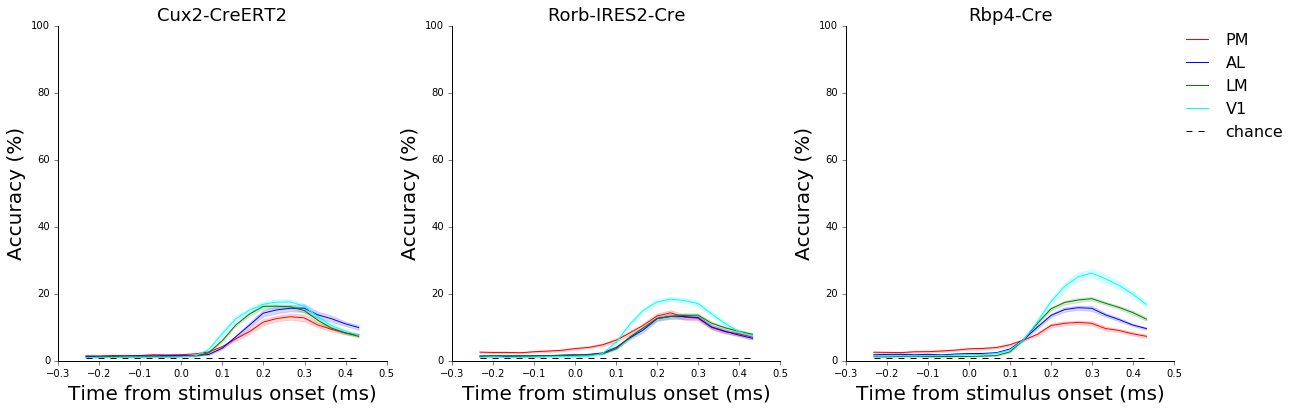

In [48]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
axs = axs.ravel()
chance = (100/float(118))*np.ones(len(xtime))
colors = ['red','blue','green','cyan']

for cc in range(num_cre_lines):
    for aa in range(num_areas):
        axs[cc].plot(xtime, mean_accuracy_time_per_cre_area[cc,:,aa], label=area_labels[aa],color=colors[aa])
        upper = mean_accuracy_time_per_cre_area[cc,:,aa] + std_accuracy_time_per_cre_area[cc,:,aa]
        lower = mean_accuracy_time_per_cre_area[cc,:,aa] - std_accuracy_time_per_cre_area[cc,:,aa]
        axs[cc].fill_between(xtime,upper,lower, alpha=0.15,color=colors[aa])
    axs[cc].plot(xtime,chance,ls='--',color='black',label='chance')

    axs[cc].spines["top"].set_visible(False)
    axs[cc].spines["right"].set_visible(False)
    axs[cc].get_xaxis().tick_bottom()
    axs[cc].get_yaxis().tick_left()
    axs[cc].tick_params(axis='both',direction='out')
    axs[cc].set_title(cre_lines[cc],fontsize=18)
    axs[cc].set_ylim(0,100)

    axs[cc].set_xlabel('Time from stimulus onset (ms)', fontsize=20)
    axs[cc].set_ylabel('Accuracy (%)', fontsize=20)

plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy per visual area per cell type1'+ add_filename +'.pdf') as pdf:
    pdf.savefig(fig)

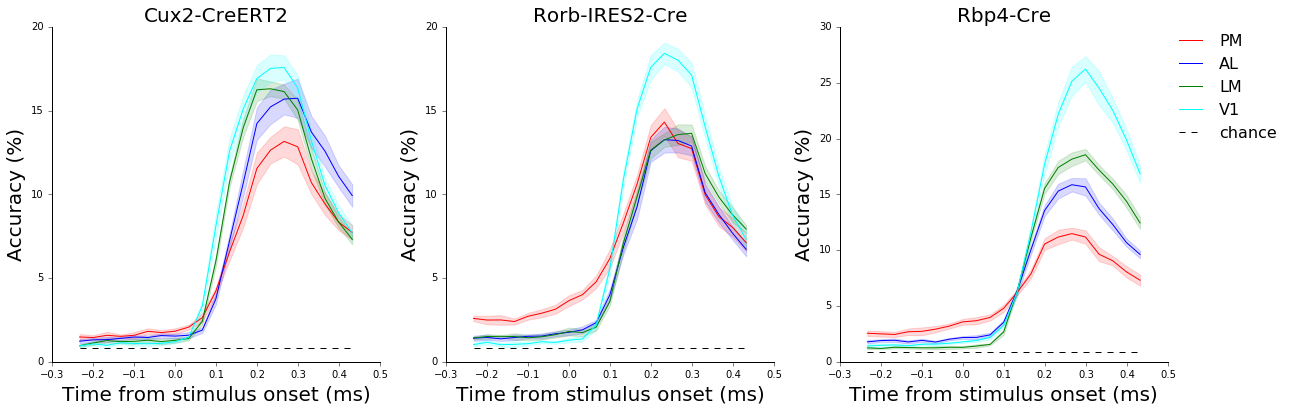

In [49]:
fig, axs = plt.subplots(1,3, figsize=(20, 6))
axs = axs.ravel()
chance = (100/float(118))*np.ones(len(xtime))
colors = ['red','blue','green','cyan']

for cc in range(num_cre_lines):
    for aa in range(num_areas):
        axs[cc].plot(xtime, mean_accuracy_time_per_cre_area[cc,:,aa], label=area_labels[aa],color=colors[aa])
        upper = mean_accuracy_time_per_cre_area[cc,:,aa] + std_accuracy_time_per_cre_area[cc,:,aa]
        lower = mean_accuracy_time_per_cre_area[cc,:,aa] - std_accuracy_time_per_cre_area[cc,:,aa]
        axs[cc].fill_between(xtime,upper,lower, alpha=0.15,color=colors[aa])
    
    axs[cc].plot(xtime,chance,ls='--',color='black',label='chance')
   
    axs[cc].spines["top"].set_visible(False)
    axs[cc].spines["right"].set_visible(False)
    axs[cc].get_xaxis().tick_bottom()
    axs[cc].get_yaxis().tick_left()
    axs[cc].tick_params(axis='both',direction='out')
    axs[cc].set_title(cre_lines[cc],fontsize=20)

    axs[cc].set_xlabel('Time from stimulus onset (ms)', fontsize=20)
    axs[cc].set_ylabel('Accuracy (%)', fontsize=20)
    
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy per visual area per cell type2'+add_filename+ '.pdf') as pdf:
    pdf.savefig(fig)

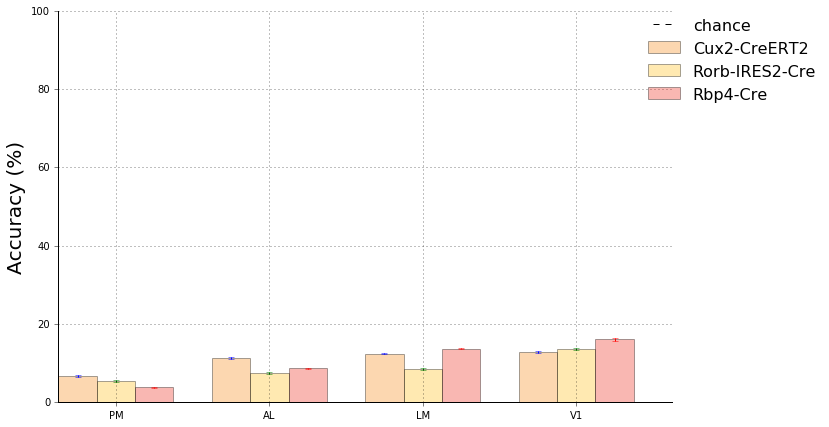

In [50]:
fig = plt.figure(figsize=(11,7))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='both',direction='out')
#ax.set_ylim(0,50)

index = np.arange(num_areas)
bar_width = 0.25
opacity = 0.35
colors =['#F78F1E','#FFC222','#EE3224']
for cc in range(num_cre_lines):
    plt.bar(index+(cc*bar_width),mean_accuracy_per_cre_area[:,cc],width=bar_width,alpha=opacity, color=colors[cc],
            label=cre_lines[cc],yerr=std_accuracy_per_cre_area[:,cc])

ax.set_ylim(0,100)
chance = (100 * 1 /(1 + num_classes)) * np.ones(len(index))
xs = np.linspace(0,4,num=4)
plt.plot(xs, chance, ls='--', color='black',label='chance')
plt.ylabel('Accuracy (%)',fontsize=20)
plt.xticks(index + 1.5 * bar_width,area_labels)
plt.grid()
plt.legend(bbox_to_anchor=(0.95, 1), loc=2, borderaxespad=0.,frameon=False,fontsize=16)

with PdfPages('Decoder accuracy per visual area per cell type3'+add_filename+'.pdf') as pdf:
    pdf.savefig(fig) 